In [1]:
import pandas as pd
import numpy as np

#import glob

from pathlib import Path

In [2]:
# Machine-learning specific imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import model_from_json

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [3]:
## Load pickle for exports and imports of data  
import pickle 
def load_obj(path):
    with open(path, 'rb') as f:
        return pickle.load(f)
    
def save_obj(obj, path ):
    with open(path, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [4]:
## API Imports 
import os
import requests
import json

from dotenv import load_dotenv
load_dotenv()

## FMP Constants 
fmpbase_urlv3 = 'https://fmpcloud.io/api/v3/'
fmpbase_urlv4 = 'https://fmpcloud.io/api/v4/'
api_key = os.getenv("FMP_CLOUD_API_KEY")

start_date = '2022-01-01'
end_date = '2022-01-31'

## FMP Functions 
def get_FMP_historical_data(symbol, startDate=start_date, endDate=end_date, apiKey=api_key):
    url_hist_price = fmpbase_urlv3+'historical-price-full/'
    url_hist_query_with_date = url_hist_price+symbol+'?from='+startDate+'&to='+endDate+'&apikey='+apiKey
    resp_data = requests.get(url_hist_query_with_date)
    json_ = resp_data.json()
    data = json_['historical']
    df = pd.DataFrame(data)
    df.rename(columns={'date':'Date'},inplace=True)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.reindex(index=df.index[::-1]) ## Reverse the DataFrame 
    df.set_index('Date',inplace=True)
    df.drop(columns='label',inplace=True)
    return df

In [5]:
def get_updated_data(symbol):
    path = Path('../FilesExport_Updated_DFs_01_31/'+symbol+'_ti_df_no_ftd.pkl')
    data = load_obj(path)
    df = data[symbol]
    
    df_close = df[['close']]
    df_close = df_close.reset_index().rename(columns={"Date": "Close_Date"})
    
    features_df = df.reset_index().drop(columns=['close','adjClose'])
    
    #new_close_df = df_close.iloc[n_days: , :].reset_index(drop=True)
    
    ## Prevent multiple API calls each time, but use API when needed. 
    try:
        path = Path('../FilesExport_Updated_API_data/'+symbol+'_jan_2022.pkl')
        api_df = load_obj(path)
    except:
        api_df = get_FMP_historical_data(symbol)
    

    new_data = api_df[['close']]
    new_data = new_data.reset_index().rename(columns={"Date": "Close_Date"})
    #new_data = new_data.iloc[0:n_days]
    
    new_close_df = df_close.append(new_data, ignore_index=True)
    

    
    return features_df, new_close_df

In [6]:
def get_data(symbol):
    path = Path('../FilesExport_Complete_DFs_TI_noShift/'+symbol+'_TI_DF_no_shift.pkl')
    data = load_obj(path)
    df = data[symbol]

    df_close = df[['close']]
    df_close = df_close.reset_index().rename(columns={"Date": "Close_Date"})

    features_df = df.reset_index().drop(columns=['close','adjClose'])   
    
    return features_df, df_close

In [7]:
def lstm_data_transform(x_data, y_data, num_steps=5):
    """ Changes data to the format for LSTM training 
for sliding window approach """
    # Prepare the list for the transformed data
    X, y = list(), list()
    # Loop of the entire data set
    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps
        # if index is larger than the size of the dataset, we stop
        if end_ix >= x_data.shape[0]:
            break
        # Get a sequence of data for x
        seq_X = x_data[i:end_ix]
        # Get only the last element of the sequency for y
        seq_y = y_data[end_ix]
        # Append the list with sequencies
        X.append(seq_X)
        y.append(seq_y)
    # Make final arrays
    x_array = np.array(X)
    y_array = np.array(y)
    return x_array, y_array

In [8]:
def load_and_predict_model(symbol):
    import_path='../Model_Data/LSTM_Model_Data_1/'
    model_type = 'LSTM'
    #n_days_string = str(n_days)
    import_path_prefix = import_path+symbol+'_'+model_type

    file_path = Path(import_path_prefix+'_model_data.json')
    with open(file_path, "r") as json_file:
        model_json = json_file.read()
    loaded_model = model_from_json(model_json)

    # load weights into new model
    file_path = Path(import_path_prefix+'_model_weights.h5')
    loaded_model.load_weights(file_path)

    ## Load model summary 
    file_path = Path(import_path_prefix+'_model_results.pkl')
    model_summary = load_obj(file_path)

    #pred_df = model_summary['prediction_df']

    time_step = model_summary['num_time_steps']

    new_features, new_close = get_data(symbol)


    X = new_features.set_index('Date')
    y = new_close.set_index('Close_Date')

    split_var = 0.9

    ## Split data
    split = int(split_var * len(X))
    x_train = X[: split]
    x_test = X[split:]
    y_train = y[: split]
    y_test = y[split:]

    ## Scale data 
    from sklearn.preprocessing import StandardScaler
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()

    x_train_sc = scaler_x.fit_transform(x_train)
    x_test_sc = scaler_x.transform(x_test)
    y_train_sc = scaler_y.fit_transform(y_train)
    y_test_sc = scaler_y.transform(y_test)

    num_steps = time_step
    # training set
    (x_train_transformed,
     y_train_transformed) = lstm_data_transform(x_train_sc, y_train_sc, num_steps=num_steps)
    assert x_train_transformed.shape[0] == y_train_transformed.shape[0]
    # test set
    (x_test_transformed,
     y_test_transformed) = lstm_data_transform(x_test_sc, y_test_sc, num_steps=num_steps)
    assert x_test_transformed.shape[0] == y_test_transformed.shape[0]
    
    test_predict = loaded_model.predict(x_test_transformed)
    
    ## Attempt inverse transform 
    predicted_prices = scaler_y.inverse_transform(test_predict)
    real_prices = scaler_y.inverse_transform(y_test_transformed)

    prediction_df = pd.DataFrame({
        'Actual':real_prices.ravel(),
        'Prediction':predicted_prices.ravel()
    })
    
    model_data_dict = {}
    
    model_data_dict[symbol] = {
        'prediction_df':prediction_df,
        'model_summary':model_summary
    }

    return model_data_dict

C:\Users\watso\anaconda3\envs\mlenv\lib\site-packages\sklearn\base.py:338: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.1 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


<AxesSubplot:>

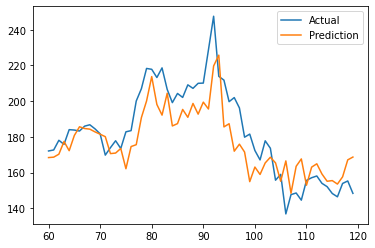

In [13]:
symbol = 'GME'
days_to_plot = 60

model_data = load_and_predict_model(symbol)

new_pred_df = model_data[symbol]['prediction_df']

new_pred_df[['Actual','Prediction']].tail(days_to_plot).plot(use_index=True)

In [10]:
# model_summary = model_data[symbol]['model_summary']
# model_summary

In [11]:
## Import
path = Path('../Resources/LSTM_model_acc_dict_1.pkl')
symbol_list = load_obj(path)
len(symbol_list)

770

In [12]:
acc_df = pd.DataFrame.from_dict(symbol_list,orient='index')
acc_df.sort_values('acc_score')

,acc_score
AYTU,0.000158
MTP,0.000178
PSHG,0.000194
BPTH,0.000280
CYCC,0.000297
...,...
DDS,34.695141
VTNR,65.813507
CAR,82.900650
AEHR,157.603210
